author: Samuel Begg

date: 06/04/2024

Compute Fisher information for a periodically driven XY model, as discussed in Mishra, Bayat, Phys. Rev. Lett. 127, 080504 (2021)

1. Define simulation parameters

In [1]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
from joblib import Parallel, delayed

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Projects/Sensing/'

# System parameters for periodic boundary condition spin chain.
J = 1.0
gamma = 1.0
h1 = 0 # The periodic field is set to zero when considering the ground-state
sites = 6
boundary_conditions = 'ABC' #'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions

# Notes: 
# The boundary conditions reflects the fermion parity of the ground-state.
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.

#Initial state
initial_state = 'ground_state' 

# Sensing parameters
phasepoints = 401 # points to sampling h0
h0mat = np.linspace(-2.5,2.5,phasepoints)  # range of points to sample
sub_system_range = np.arange(1,int(sites)+1) # range of subsystem sizes for evaluating Fisher information

# Computational 
tol = 10**(-6) # when evaluating the Fisher information we don't consider singular terms for which |w[rr] + w[ss]| < tol 
shift = 0.000001 # finite division size for calculating derivative of reduced density matrix, i.e. drho/dh0 ~ (rho(h0) - rho(h0 + shift))/shift for the order2 version
derivative_estimator = 'order2' # 2nd order = 'order2' or 4th order 'order4' approximation for the derivative of reduced density matrix
num_cores = 16  # number of cores to parallelize with
save_results = 'bin' # 'save' or 'bin' (don't save)



2. Calculate Fisher information for ground state

In [2]:
Fishermat = np.zeros([np.size(sub_system_range),np.size(h0mat)])

#Calculate fisher information for different subsystem sizes and h0 values
#Fisher = Fisher_Groundstate(J, gamma, h0mat[uu], h1[0], sites, sub_system_range, tol, shift, derivative_estimator)
Fishermat = Parallel(n_jobs=num_cores)(delayed(methods.Fisher_Groundstate)(J, gamma, h0mat[uu], h1, sites, sub_system_range, tol, shift, derivative_estimator, boundary_conditions) for uu in range(0,np.size(h0mat)))

Fishermat= np.asarray(Fishermat)

Number of avoided divergences [ 0.  0.  0.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.001857 End Fisher Calculation
Number of avoided divergences [ 0.  0.  0.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.001570Number of avoided divergences [ 0.  0.  0.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.001813 End Fisher Calculation
 End Fisher CalculationNumber of avoided divergences Number of avoided divergences [ 0.  0.  0.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.001754 End Fisher Calculation
[ 0.  0.  0.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.004520 End Fisher Calculation
Number of avoided divergences [ 0.  0.  0.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.001726 End Fisher Calculation
Number of avoided divergences [ 0.  0.  0.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.001748 End Fisher Calculation
Number of avoided divergences [ 0.  0.  0.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.002926 End Fisher Calculation

Number of avoided divergences [ 0.  0.  0.  8. 32. 72.]


3. Calculate ground state Fisher information for different gamma values

In [3]:
#Want to see scaling for some different gamma values too
gmat = [0.1,0.5,1]

FishermatGamma = Parallel(n_jobs=num_cores)(delayed(methods.Fisher_Groundstate)(J, gmat[gg], 1.0, h1, sites, sub_system_range, tol, shift, derivative_estimator, boundary_conditions) for gg in range(0,np.size(gmat)))

FishermatGamma= np.asarray(FishermatGamma)

Number of avoided divergences [ 0.  0.  2.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.001702 End Fisher Calculation
Number of avoided divergences [ 0.  0.  0.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.001559 End Fisher Calculation
Number of avoided divergences [ 0.  0.  0.  8. 32. 72.]
subsystem [1 2 3 4 5 6]
0:00:00.001781 End Fisher Calculation


Plot Fisher information for groundstates

/Users/samuelbegg/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/samuelbegg/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


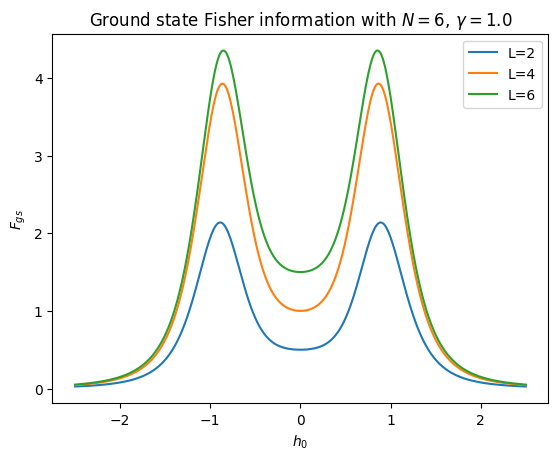

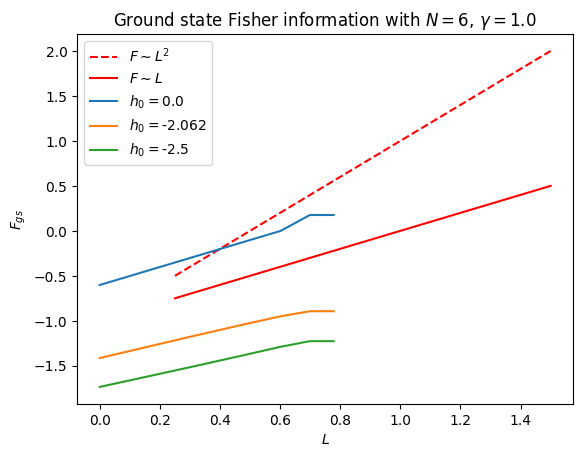

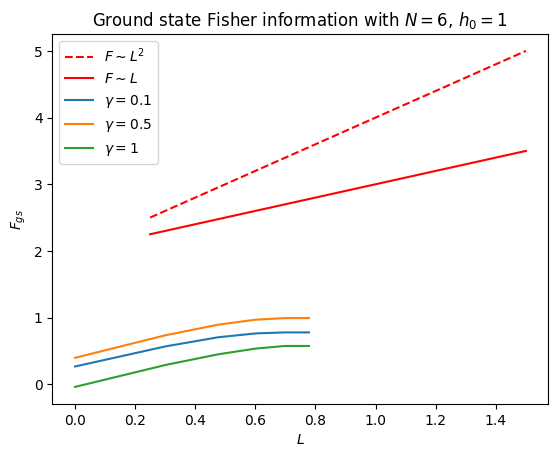

In [4]:

if save_results == 'save':
    
    np.save('gmat.npy',gmat)
    np.save('Fisher_mat_Gamma.npy',FishermatGamma)
    np.save('h0mat.npy',h0mat)
    np.save('Fisher_mat.npy',Fishermat)
    np.save('subsystem.npy',sub_system_range)

import matplotlib.pyplot as plt

for ss in range(1,np.size(sub_system_range),2):

    plt.plot(h0mat,Fishermat[:,ss],label = 'L=' + str(sub_system_range[ss]))

plt.ylabel(r'$F_{gs}$')
plt.xlabel(r'$h_0$')
plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
plt.legend()
plt.show()

x = np.linspace(0.25,1.5,1000)
plt.plot(x,2*x-1,'--r',label = r'$F \sim L^{2}$')
plt.plot(x,x-1,'-r',label = r'$F \sim L$')
plt.plot(np.log10(sub_system_range),np.log10(Fishermat[int(np.size(h0mat)/2),:]),label = r'$h_0=$' + str(np.round(h0mat[int(np.size(h0mat)/2)],3)))
plt.plot(np.log10(sub_system_range),np.log10(Fishermat[35,:]),label = r'$h_0=$' + str(np.round(h0mat[35],3)))
plt.plot(np.log10(sub_system_range),np.log10(Fishermat[7,:]),label = r'$h_0=$' + str(np.round(h0mat[0],3)))
plt.xlabel(r'$L$')
plt.ylabel(r'$F_{gs}$')
plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
plt.legend()
plt.show()

x = np.linspace(0.25,1.5,1000)
plt.plot(x,2*x+2,'--r',label = r'$F \sim L^{2}$')
plt.plot(x,x+2,'-r',label = r'$F \sim L$')
plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[0,:]),label = r'$\gamma=$' + str(np.round(gmat[0],3)))
plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[1,:]),label = r'$\gamma=$' + str(np.round(gmat[1],3)))
plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[2,:]),label = r'$\gamma=$' + str(np.round(gmat[2],3)))
plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $h_0=1$')
plt.xlabel(r'$L$')
plt.ylabel(r'$F_{gs}$')
plt.legend()
plt.show()


/Users/samuelbegg/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/samuelbegg/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


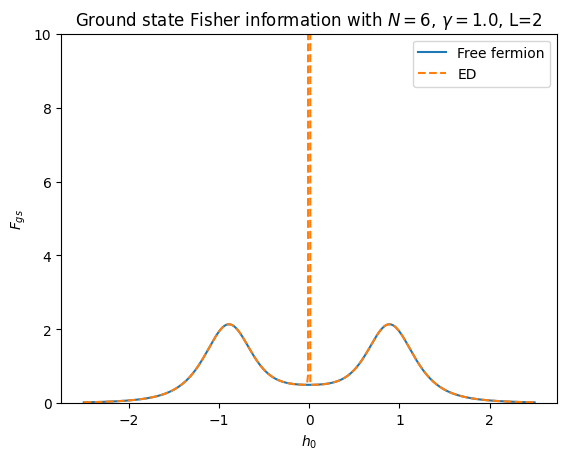

In [9]:
#Comparison vs ED

ss = 1
plt.plot(h0mat,Fishermat[:,ss],label = 'Free fermion')

ED_fisher = np.load('/Users/samuelbegg/Documents/Projects/Sensing/ed_results/Fisher.npy')
hzmat = np.load('/Users/samuelbegg/Documents/Projects/Sensing/ed_results/hzmat.npy')

plt.plot(hzmat,ED_fisher,'--',label='ED')
plt.ylabel(r'$F_{gs}$')
plt.xlabel(r'$h_0$')
plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma) + ', L=' + str(sub_system_range[ss]))
plt.legend()
plt.ylim(0,10)
plt.show()